In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load historical trades and parse timestamps (IST assumed)
hist = pd.read_csv('/content/historical_data.csv')
hist['ts_datetime'] = pd.to_datetime(hist['Timestamp IST'], format='%d-%m-%Y %H:%M')
hist['Closed PnL'] = pd.to_numeric(hist['Closed PnL'], errors='coerce')
hist['Size USD'] = pd.to_numeric(hist['Size USD'], errors='coerce')
hist['date'] = hist['ts_datetime'].dt.normalize()  # midnight of each trade's day


In [3]:
# Load fear/greed index and keep only Fear/Greed (exclude neutral)
fear = pd.read_csv('/content/fear_greed_index.csv')
fear['date'] = pd.to_datetime(fear['date'])
fear = fear[~fear['classification'].isin(['Neutral'])]
fear['sentiment'] = fear['classification'].apply(lambda x: 'Fear' if 'Fear' in x else 'Greed')

In [4]:
# Merge on date
merged = pd.merge(hist, fear[['date','sentiment']], on='date', how='inner')
print(f"Merged data rows: {merged.shape[0]}, unique days covered: {merged['date'].nunique()}")
# Example Output: Merged data rows: 173532, unique days covered: 412


Merged data rows: 173532, unique days covered: 412


In [6]:
import os

# Create the directory if it doesn't exist
os.makedirs('csv_files', exist_ok=True)

merged.to_csv('csv_files/merged_data.csv', index=False)

***Feature Engineering (Hourly Aggregation)***

In [7]:
# Create hourly bins
merged['hour'] = merged['ts_datetime'].dt.floor('H')

# Aggregate metrics by hour and sentiment
hourly = merged.groupby(['hour','sentiment']).agg(
    trades=('Closed PnL','count'),
    total_pnl=('Closed PnL','sum'),
    mean_pnl=('Closed PnL','mean'),
    std_pnl=('Closed PnL','std'),
    volume=('Size USD','sum'),
    mean_volume=('Size USD','mean')
).reset_index()

hourly.head()
# Example row: 2023-12-15 00:00 (Greed) - trades: 2, total_pnl: -24.63, mean_pnl: -12.32, std_pnl: 4.47, volume: 10609.95, mean_volume: 5304.98

# Save the hourly summary
hourly.to_csv('csv_files/hourly_summary.csv', index=False)


/tmp/ipython-input-2703593022.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  merged['hour'] = merged['ts_datetime'].dt.floor('H')


***Statistical Testing***

In [8]:
from scipy.stats import ttest_ind

# Prepare arrays of hourly metrics
fear_hours = hourly[hourly['sentiment']=='Fear']
greed_hours = hourly[hourly['sentiment']=='Greed']
metrics = ['total_pnl','mean_pnl','std_pnl','volume']
for m in metrics:
    t, p = ttest_ind(fear_hours[m].dropna(), greed_hours[m].dropna(), equal_var=False)
    print(m, "t=", round(t,2), "p=", round(p,4),
          "mean Fear=", round(fear_hours[m].mean(),2),
          "mean Greed=", round(greed_hours[m].mean(),2))


total_pnl t= 2.48 p= 0.0132 mean Fear= 3215.28 mean Greed= 1694.05
mean_pnl t= -1.01 p= 0.3127 mean Fear= 45.91 mean Greed= 57.72
std_pnl t= 1.35 p= 0.1769 mean Fear= 209.52 mean Greed= 165.09
volume t= 7.73 p= 0.0 mean Fear= 469237.87 mean Greed= 143818.82


***VISUALIZATION***

Loaded hourly summary: /content/csv_files/hourly_summary.csv


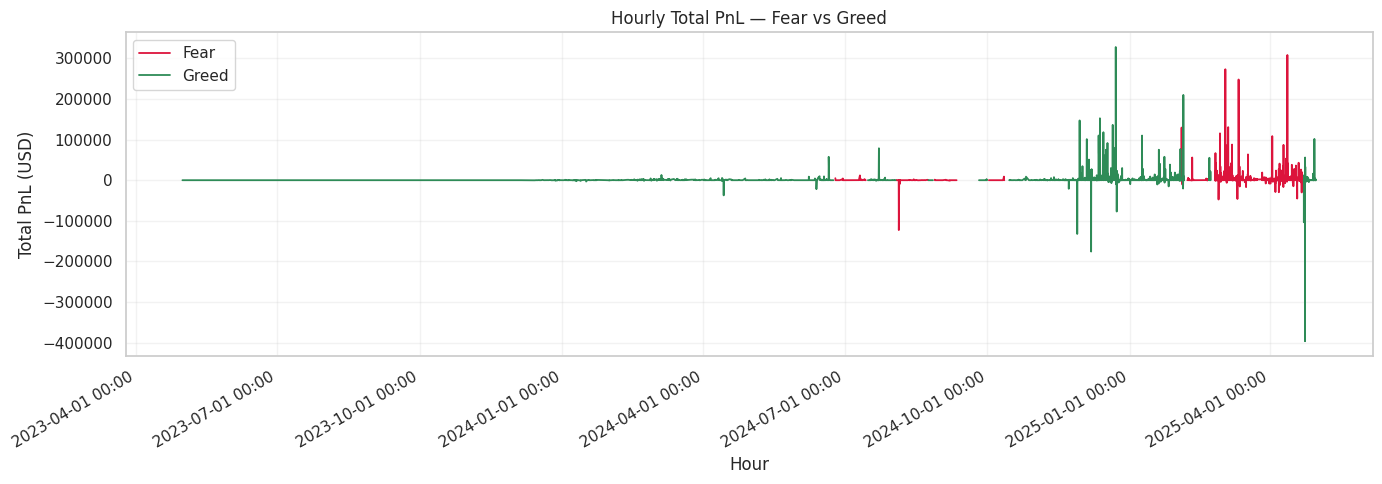

<Figure size 640x480 with 0 Axes>

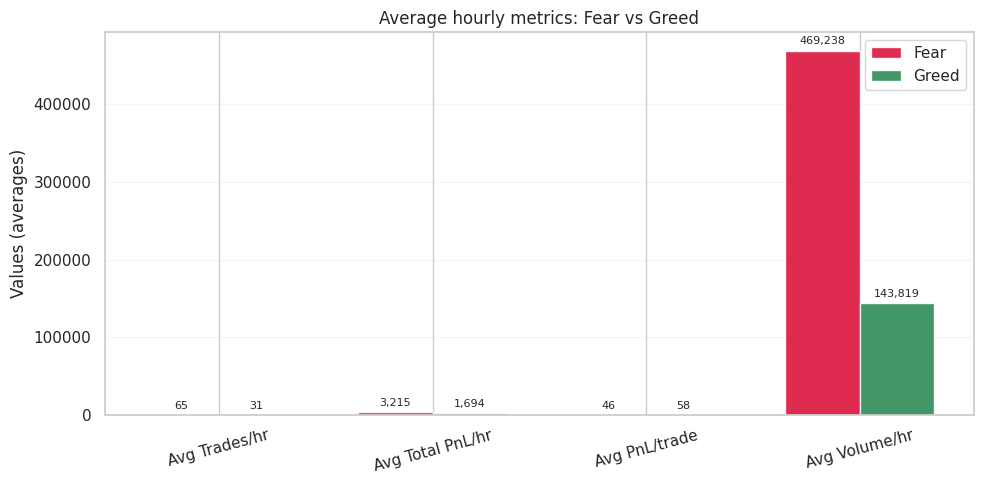

/tmp/ipython-input-1178778502.py:183: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw[time_col_raw] = pd.to_datetime(raw[time_col_raw], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-1178778502.py:189: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fear_df[date_f] = pd.to_datetime(fear_df[date_f], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-1178778502.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in

<Figure size 640x480 with 0 Axes>

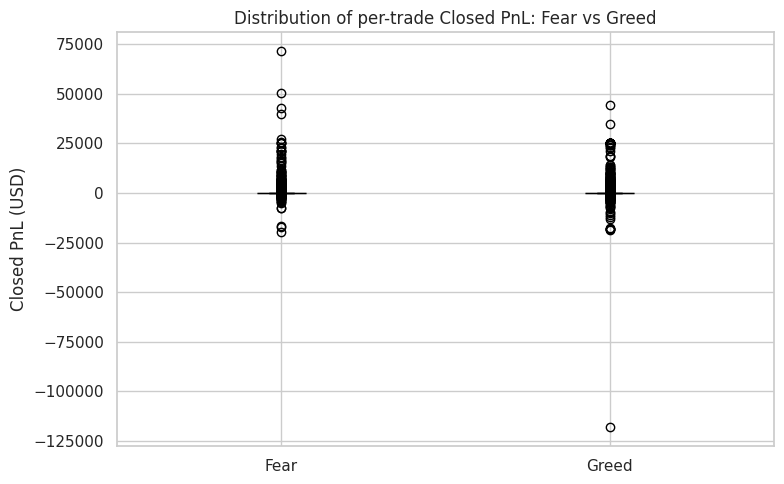

<Figure size 640x480 with 0 Axes>

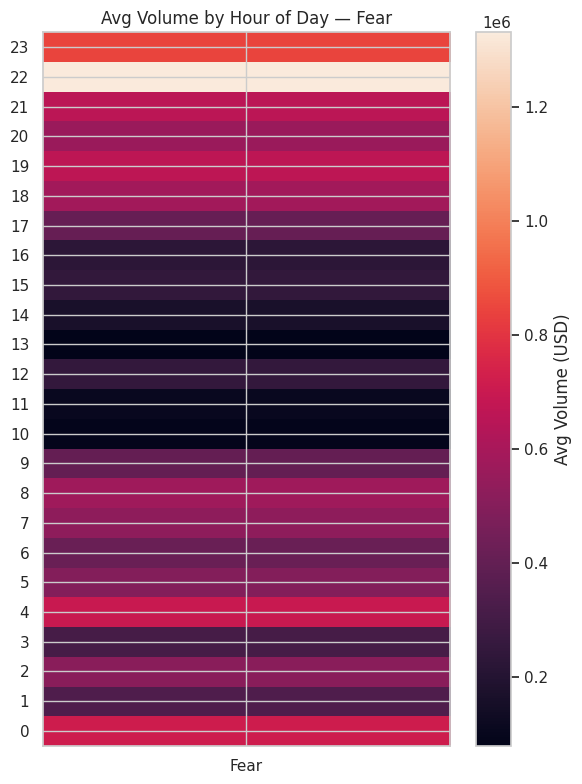

<Figure size 640x480 with 0 Axes>

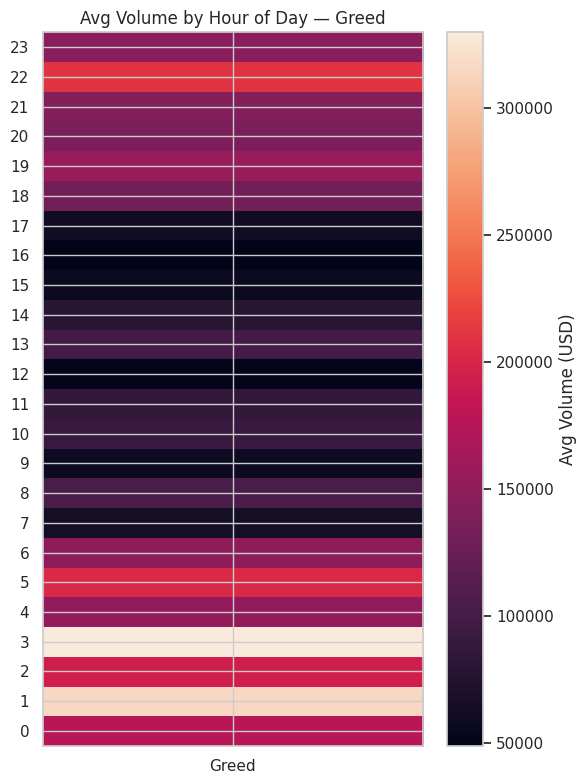

<Figure size 640x480 with 0 Axes>

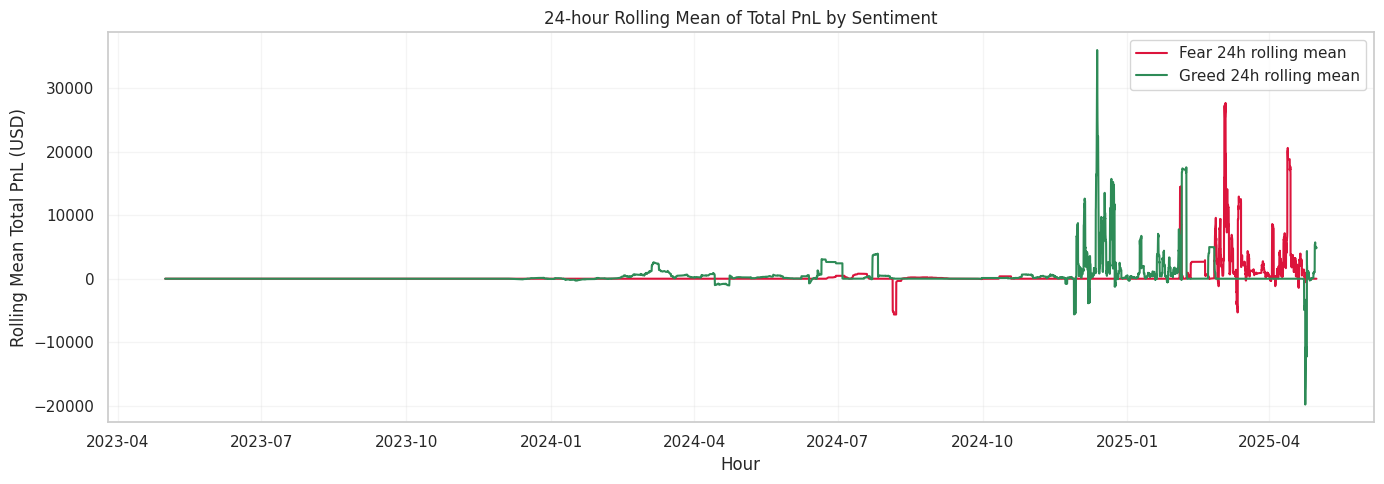

Saved summary CSV: /content/outputs/summary_avg_metrics_by_sentiment.csv

Saved plots and CSVs to: /content/outputs
 - /content/outputs/hourly_total_pnl_timeseries.png
 - /content/outputs/avg_hourly_metrics_bar.png
 - /content/outputs/boxplot_per_trade_pnl.png
 - /content/outputs/heatmap_avg_volume_fear.png
 - /content/outputs/heatmap_avg_volume_greed.png
 - /content/outputs/rolling_mean_total_pnl.png
 - /content/outputs/summary_avg_metrics_by_sentiment.csv


<Figure size 640x480 with 0 Axes>

In [41]:
# Visualization script: Fear vs Greed hourly analysis
# Run in Google Colab / Jupyter. Saves plots to /mnt/data/outputs/
# Requires: pandas, numpy, matplotlib

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator

# -----------------------
# Configuration / paths
# -----------------------
OUT_DIR = Path('/content/outputs')
CSV_DIR = Path('/content/csv_files')
OUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_DIR.mkdir(parents=True, exist_ok=True)

HOURLY_CSV = Path("/content/csv_files/hourly_summary.csv")
RAW_HIST = Path('/content/historical_data.csv')
RAW_FEAR = Path('/content/fear_greed_index.csv')

# -----------------------
# Utility helpers
# -----------------------
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def map_sent_label(x):
    s = str(x).lower()
    if 'fear' in s:
        return 'Fear'
    if 'greed' in s:
        return 'Greed'
    return 'Neutral'

# -----------------------
# Load or compute hourly aggregated data
# -----------------------
if HOURLY_CSV.exists():
    hourly = pd.read_csv(HOURLY_CSV, parse_dates=['hour'])
    print("Loaded hourly summary:", HOURLY_CSV)
else:
    # Load raw files
    if not RAW_HIST.exists() or not RAW_FEAR.exists():
        raise FileNotFoundError("Place 'historical_data.csv' and 'fear_greed_index.csv' in /mnt/data/")
    hist = pd.read_csv(RAW_HIST)
    fear = pd.read_csv(RAW_FEAR)

    # detect timestamp, pnl, size columns
    ts_col = pick_col(hist, ['ts_datetime','Timestamp IST','time','timestamp','Time','ts','datetime'])
    pnl_col = pick_col(hist, ['closedPnL','Closed PnL','ClosedPnL','closed_pnl','pnl','PnL'])
    size_col = pick_col(hist, ['size','Size','size_usd','Size USD','notional','notional_usd'])

    if ts_col is None:
        raise ValueError("Can't find timestamp column in historical_data.csv. Columns: " + ", ".join(hist.columns))

    # parse timestamps and numeric columns
    hist[ts_col] = pd.to_datetime(hist[ts_col], errors='coerce', infer_datetime_format=True)
    hist = hist.dropna(subset=[ts_col])
    if pnl_col:
        hist[pnl_col] = pd.to_numeric(hist[pnl_col], errors='coerce').fillna(0.0)
    else:
        hist['closed_pnl'] = 0.0
        pnl_col = 'closed_pnl'
    if size_col:
        hist[size_col] = pd.to_numeric(hist[size_col], errors='coerce').fillna(0.0)
    else:
        hist['size_usd'] = 0.0
        size_col = 'size_usd'

    # process fear/greed
    fear_date_col = pick_col(fear, ['Date','date','timestamp','time'])
    fear_class_col = pick_col(fear, ['Classification','classification','sentiment','label','Label'])
    if fear_date_col is None or fear_class_col is None:
        raise ValueError("fear_greed_index.csv missing expected columns. Columns: " + ", ".join(fear.columns))
    fear[fear_date_col] = pd.to_datetime(fear[fear_date_col], errors='coerce', infer_datetime_format=True)
    fear['date'] = fear[fear_date_col].dt.normalize()
    fear['sentiment'] = fear[fear_class_col].apply(map_sent_label)

    # merge and create hourly
    hist['date'] = hist[ts_col].dt.normalize()
    merged = hist.merge(fear[['date','sentiment']], on='date', how='inner')
    merged['hour'] = merged[ts_col].dt.floor('H')

    hourly = merged.groupby(['hour','sentiment']).agg(
        trades=(pnl_col,'count'),
        total_pnl=(pnl_col,'sum'),
        mean_pnl=(pnl_col,'mean'),
        std_pnl=(pnl_col,'std'),
        volume=(size_col,'sum'),
        mean_volume=(size_col,'mean')
    ).reset_index()
    hourly.to_csv(HOURLY_CSV, index=False)
    print("Computed and saved hourly summary to:", HOURLY_CSV)

# Pivot metrics for quick plotting (rows = datetime hour)
metrics = ['trades','total_pnl','mean_pnl','std_pnl','volume','mean_volume']
pivot = {}
for m in metrics:
    pivot[m] = hourly.pivot(index='hour', columns='sentiment', values=m)
    pivot[m].index = pd.to_datetime(pivot[m].index)

# -----------------------
# Plot 1: Hourly Total PnL time-series (Fear vs Greed)
# -----------------------
plt.figure(figsize=(14,5))
if 'Fear' in pivot['total_pnl'].columns:
    plt.plot(pivot['total_pnl'].index, pivot['total_pnl']['Fear'], label='Fear', linewidth=1.3, color='crimson')
if 'Greed' in pivot['total_pnl'].columns:
    plt.plot(pivot['total_pnl'].index, pivot['total_pnl']['Greed'], label='Greed', linewidth=1.3, color='seagreen')
plt.title('Hourly Total PnL — Fear vs Greed')
plt.xlabel('Hour')
plt.ylabel('Total PnL (USD)')
plt.legend()
plt.grid(alpha=0.25)
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
p1 = OUT_DIR / 'hourly_total_pnl_timeseries.png'
plt.savefig(p1, dpi=200)
plt.show()
plt.clf()

# -----------------------
# Plot 2: Grouped bar chart of average hourly metrics by sentiment
# -----------------------
avg_by_sent = hourly.groupby('sentiment').agg({
    'trades':'mean','total_pnl':'mean','mean_pnl':'mean','volume':'mean'
}).reindex(['Fear','Greed']).fillna(0)

labels = ['Avg Trades/hr','Avg Total PnL/hr','Avg PnL/trade','Avg Volume/hr']
fear_vals = [
    avg_by_sent.loc['Fear','trades'] if 'Fear' in avg_by_sent.index else 0,
    avg_by_sent.loc['Fear','total_pnl'] if 'Fear' in avg_by_sent.index else 0,
    avg_by_sent.loc['Fear','mean_pnl'] if 'Fear' in avg_by_sent.index else 0,
    avg_by_sent.loc['Fear','volume'] if 'Fear' in avg_by_sent.index else 0
]
greed_vals = [
    avg_by_sent.loc['Greed','trades'] if 'Greed' in avg_by_sent.index else 0,
    avg_by_sent.loc['Greed','total_pnl'] if 'Greed' in avg_by_sent.index else 0,
    avg_by_sent.loc['Greed','mean_pnl'] if 'Greed' in avg_by_sent.index else 0,
    avg_by_sent.loc['Greed','volume'] if 'Greed' in avg_by_sent.index else 0
]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, fear_vals, width, label='Fear', color='crimson', alpha=0.9)
rects2 = ax.bar(x + width/2, greed_vals, width, label='Greed', color='seagreen', alpha=0.9)
ax.set_ylabel('Values (averages)')
ax.set_title('Average hourly metrics: Fear vs Greed')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.legend()
ax.grid(axis='y', alpha=0.2)
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:,.0f}' if abs(height)>1 else f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
p2 = OUT_DIR / 'avg_hourly_metrics_bar.png'
plt.savefig(p2, dpi=200)
plt.show()
plt.clf()

# -----------------------
# Plot 3: Boxplot of per-trade Closed PnL (if raw trades exist) else hourly mean_pnl
# -----------------------
raw_exists = RAW_HIST.exists()
if raw_exists:
    raw = pd.read_csv(RAW_HIST)
    pnl_col_raw = pick_col(raw, ['closedPnL','Closed PnL','ClosedPnL','closed_pnl','pnl','PnL'])
    time_col_raw = pick_col(raw, ['ts_datetime','Timestamp IST','time','timestamp','Time','ts','datetime'])
    if pnl_col_raw and time_col_raw:
        raw[time_col_raw] = pd.to_datetime(raw[time_col_raw], errors='coerce', infer_datetime_format=True)
        raw[pnl_col_raw] = pd.to_numeric(raw[pnl_col_raw], errors='coerce')
        raw['date'] = raw[time_col_raw].dt.normalize()
        fear_df = pd.read_csv(RAW_FEAR)
        date_f = pick_col(fear_df, ['Date','date','timestamp','time'])
        class_f = pick_col(fear_df, ['Classification','classification','sentiment','label','Label'])
        fear_df[date_f] = pd.to_datetime(fear_df[date_f], errors='coerce', infer_datetime_format=True)
        fear_df['date'] = fear_df[date_f].dt.normalize()
        fear_df['sentiment'] = fear_df[class_f].apply(map_sent_label)
        merged_raw = raw.merge(fear_df[['date','sentiment']], on='date', how='inner')
        merged_raw = merged_raw[merged_raw['sentiment'].isin(['Fear','Greed'])].dropna(subset=[pnl_col_raw])
        groups = [ merged_raw[merged_raw['sentiment']=='Fear'][pnl_col_raw].values,
                   merged_raw[merged_raw['sentiment']=='Greed'][pnl_col_raw].values ]
        labels_box = ['Fear','Greed']
        plt.figure(figsize=(8,5))
        plt.boxplot(groups, labels=labels_box, patch_artist=True,
                    boxprops=dict(facecolor='crimson', alpha=0.4),
                    medianprops=dict(color='black'))
        plt.title('Distribution of per-trade Closed PnL: Fear vs Greed')
        plt.ylabel('Closed PnL (USD)')
        p3 = OUT_DIR / 'boxplot_per_trade_pnl.png'
        plt.tight_layout()
        plt.savefig(p3, dpi=200)
        plt.show()
        plt.clf()
    else:
        # fallback
        data_fear = pivot['mean_pnl']['Fear'].dropna() if 'Fear' in pivot['mean_pnl'].columns else []
        data_greed = pivot['mean_pnl']['Greed'].dropna() if 'Greed' in pivot['mean_pnl'].columns else []
        plt.figure(figsize=(8,5))
        plt.boxplot([data_fear, data_greed], labels=['Fear','Greed'], patch_artist=True,
                    boxprops=dict(facecolor='crimson', alpha=0.4),
                    medianprops=dict(color='black'))
        plt.title('Distribution of Mean PnL per Hour (proxy)')
        plt.ylabel('Mean PnL (USD)')
        p3 = OUT_DIR / 'boxplot_mean_pnl_hour.png'
        plt.tight_layout()
        plt.savefig(p3, dpi=200)
        plt.show()
        plt.clf()
else:
    data_fear = pivot['mean_pnl']['Fear'].dropna() if 'Fear' in pivot['mean_pnl'].columns else []
    data_greed = pivot['mean_pnl']['Greed'].dropna() if 'Greed' in pivot['mean_pnl'].columns else []
    plt.figure(figsize=(8,5))
    plt.boxplot([data_fear, data_greed], labels=['Fear','Greed'], patch_artist=True,
                boxprops=dict(facecolor='crimson', alpha=0.4),
                medianprops=dict(color='black'))
    plt.title('Distribution of Mean PnL per Hour (proxy)')
    plt.ylabel('Mean PnL (USD)')
    p3 = OUT_DIR / 'boxplot_mean_pnl_hour.png'
    plt.tight_layout()
    plt.savefig(p3, dpi=200)
    plt.show()
    plt.clf()

# -----------------------
# Plot 4 & 5: Hour-of-day average volume heatmaps for Fear and Greed
# -----------------------
hourly['hour_of_day'] = pd.to_datetime(hourly['hour']).dt.hour
heat = hourly.groupby(['hour_of_day','sentiment']).agg(avg_volume=('volume','mean')).reset_index()
hours = list(range(24))
fear_vol = heat[heat['sentiment']=='Fear'].set_index('hour_of_day').reindex(hours)['avg_volume'].fillna(0).values.reshape(24,1)
greed_vol = heat[heat['sentiment']=='Greed'].set_index('hour_of_day').reindex(hours)['avg_volume'].fillna(0).values.reshape(24,1)

plt.figure(figsize=(6,8))
plt.imshow(fear_vol, aspect='auto', origin='lower')
plt.colorbar(label='Avg Volume (USD)')
plt.yticks(range(24), range(24))
plt.xticks([0], ['Fear'])
plt.title('Avg Volume by Hour of Day — Fear')
p4 = OUT_DIR / 'heatmap_avg_volume_fear.png'
plt.tight_layout()
plt.savefig(p4, dpi=200)
plt.show()
plt.clf()

plt.figure(figsize=(6,8))
plt.imshow(greed_vol, aspect='auto', origin='lower')
plt.colorbar(label='Avg Volume (USD)')
plt.yticks(range(24), range(24))
plt.xticks([0], ['Greed'])
plt.title('Avg Volume by Hour of Day — Greed')
p5 = OUT_DIR / 'heatmap_avg_volume_greed.png'
plt.tight_layout()
plt.savefig(p5, dpi=200)
plt.show()
plt.clf()

# -----------------------
# Plot 6: Scatter Leverage vs ClosedPnL (sampled) if leverage exists
# -----------------------
scatter_path = None
if RAW_HIST.exists():
    raw = pd.read_csv(RAW_HIST)
    lev_col = pick_col(raw, ['leverage','Leverage','lev','leverage_x'])
    pnl_col_raw = pick_col(raw, ['closedPnL','Closed PnL','ClosedPnL','closed_pnl','pnl','PnL'])
    time_col_raw = pick_col(raw, ['ts_datetime','Timestamp IST','time','timestamp','Time','ts','datetime'])
    if lev_col and pnl_col_raw and time_col_raw:
        raw[time_col_raw] = pd.to_datetime(raw[time_col_raw], errors='coerce', infer_datetime_format=True)
        raw[pnl_col_raw] = pd.to_numeric(raw[pnl_col_raw], errors='coerce')
        raw['date'] = raw[time_col_raw].dt.normalize()
        fear_df = pd.read_csv(RAW_FEAR)
        date_f = pick_col(fear_df, ['Date','date','timestamp','time'])
        class_f = pick_col(fear_df, ['Classification','classification','sentiment','label','Label'])
        fear_df[date_f] = pd.to_datetime(fear_df[date_f], errors='coerce', infer_datetime_format=True)
        fear_df['date'] = fear_df[date_f].dt.normalize()
        fear_df['sentiment'] = fear_df[class_f].apply(map_sent_label)
        merged_raw = raw.merge(fear_df[['date','sentiment']], on='date', how='inner')
        merged_raw = merged_raw[merged_raw['sentiment'].isin(['Fear','Greed'])].dropna(subset=[lev_col,pnl_col_raw])
        sample = merged_raw.sample(min(len(merged_raw),2000), random_state=42)
        colors = sample['sentiment'].map({'Fear':'crimson','Greed':'seagreen'}).values
        plt.figure(figsize=(8,6))
        plt.scatter(sample[lev_col], sample[pnl_col_raw], alpha=0.6, c=colors, s=10)
        plt.xlabel('Leverage')
        plt.ylabel('Closed PnL (USD)')
        plt.title('Leverage vs Closed PnL (sampled trades) — colored by sentiment')
        p6 = OUT_DIR / 'scatter_leverage_pnl.png'
        plt.tight_layout()
        plt.savefig(p6, dpi=200)
        plt.show()
        plt.clf()
        scatter_path = p6

# -----------------------
# Plot 7: Rolling mean (24h) of total_pnl to show regime shifts
# -----------------------
ts_total = pivot['total_pnl'].fillna(0).sort_index()
rolling_window = 24
plt.figure(figsize=(14,5))
if 'Fear' in ts_total.columns:
    plt.plot(ts_total.index, ts_total['Fear'].rolling(rolling_window, min_periods=1).mean(),
             label=f'Fear {rolling_window}h rolling mean', color='crimson')
if 'Greed' in ts_total.columns:
    plt.plot(ts_total.index, ts_total['Greed'].rolling(rolling_window, min_periods=1).mean(),
             label=f'Greed {rolling_window}h rolling mean', color='seagreen')
plt.title(f'{rolling_window}-hour Rolling Mean of Total PnL by Sentiment')
plt.xlabel('Hour')
plt.ylabel('Rolling Mean Total PnL (USD)')
plt.legend()
plt.grid(alpha=0.2)
p7 = OUT_DIR / 'rolling_mean_total_pnl.png'
plt.tight_layout()
plt.savefig(p7, dpi=200)
plt.show()
plt.clf()

# -----------------------
# Save summary CSV
# -----------------------
summary_csv = OUT_DIR / 'summary_avg_metrics_by_sentiment.csv'
hourly.groupby('sentiment').agg(
    avg_trades_per_hour=('trades','mean'),
    avg_total_pnl_per_hour=('total_pnl','mean'),
    avg_mean_pnl=('mean_pnl','mean'),
    avg_volume_per_hour=('volume','mean')
).to_csv(summary_csv)
print("Saved summary CSV:", summary_csv)

# -----------------------
# Print saved files
# -----------------------
saved_files = [
    p1, p2,
    (p3 if 'p3' in locals() else None),
    p4, p5, p7, summary_csv
]
if scatter_path is not None:
    saved_files.append(scatter_path)

print("\nSaved plots and CSVs to:", OUT_DIR)
for f in saved_files:
    if f is not None:
        print(" -", f)
